<a href="https://colab.research.google.com/github/Apratim7104/Intelligent-Temperature-Control/blob/main/Intelligent_Temperature_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random


PID CONTROLLER CLASS


In [ ]:
class PIDController:
  def __init__(self,Kp,Ki,Kd,setpoint):
    self.Kp=Kp
    self.Ki=Ki
    self.Kd=Kd
    self.setpoint=setpoint
    self.integral=0
    self.prev_error = 0

  def update(self, measured_value, dt):
        error = self.setpoint - measured_value
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output


Simulating Temperature Signal


In [ ]:
def generate_temperature_signal(duration=60, samples=600, spike_time=(30, 32), spike_magnitude=8):
    t = np.linspace(0, duration, samples)
    temperature = 25 + 2*np.sin(0.2*t) + np.random.normal(0, 0.5, len(t))

    # Inject spike
    spike_index = np.where((t > spike_time[0]) & (t < spike_time[1]))[0]
    temperature[spike_index] += spike_magnitude

    return t, temperature


Simulating PID Response + Error Metric

In [ ]:
def simulate_pid(Kp, Ki, Kd, temperature, dt, setpoint):
    pid = PIDController(Kp, Ki, Kd, setpoint)
    fan_speed = []
    error_sum = 0

    for temp in temperature:
        speed = pid.update(temp, dt)
        speed = max(0, min(100, speed))  # Clamp to 0–100%
        fan_speed.append(speed)
        error = setpoint - temp
        error_sum += error**2  # Integral of Squared Error (ISE)

    return fan_speed, error_sum


Plot Temperature and Fan Speed

In [ ]:
def plot_response(t, temperature, fan_speed, setpoint):
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 1, 1)
    plt.plot(t, temperature, label='Temperature (°C)')
    plt.axhline(setpoint, color='r', linestyle='--', label='Setpoint')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t, fan_speed, label='Fan Speed (%)', color='orange')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()


Genetic Algorithm for PID Tuning

In [ ]:
 def genetic_algorithm(temperature, dt, setpoint, generations=50, population_size=30):
    population = [
        {'Kp': random.uniform(0, 10), 'Ki': random.uniform(0, 1), 'Kd': random.uniform(0, 1)}
        for _ in range(population_size)
    ]

    for gen in range(generations):
        # Evaluate fitness
        for individual in population:
            _, fitness = simulate_pid(
                individual['Kp'], individual['Ki'], individual['Kd'],
                temperature, dt, setpoint
            )
            individual['fitness'] = fitness

        # Select top performers
        population.sort(key=lambda x: x['fitness'])
        top_half = population[:population_size // 2]

        # Generate new population
        new_population = []
        while len(new_population) < population_size:
            p1, p2 = random.sample(top_half, 2)
            child = {
                'Kp': (p1['Kp'] + p2['Kp']) / 2 + random.uniform(-0.5, 0.5),
                'Ki': (p1['Ki'] + p2['Ki']) / 2 + random.uniform(-0.05, 0.05),
                'Kd': (p1['Kd'] + p2['Kd']) / 2 + random.uniform(-0.05, 0.05)
            }
            new_population.append(child)

        population = new_population

    # ✅ Final fitness evaluation before selecting best
    for individual in population:
        _, fitness = simulate_pid(
            individual['Kp'], individual['Ki'], individual['Kd'],
            temperature, dt, setpoint
        )
        individual['fitness'] = fitness

    return min(population, key=lambda x: x['fitness'])


Raspberry Pi–Style Real-Time Loop



In [ ]:
def raspberry_pi_loop(Kp, Ki, Kd, setpoint):
    t, temperature = generate_temperature_signal()
    dt = t[1] - t[0]
    pid = PIDController(Kp, Ki, Kd, setpoint)

    print("Simulating Raspberry Pi control loop...\n")
    for i in range(len(t)):
        temp = temperature[i]
        fan_speed = pid.update(temp, dt)
        fan_speed = max(0, min(100, fan_speed))

        # Emulated GPIO output
        print(f"Time: {t[i]:.1f}s | Temp: {temp:.2f}°C | Fan Speed: {fan_speed:.1f}%")
        time.sleep(0.01)  # Simulate real-time delay


✅ Optimized PID Parameters:
{'Kp': 3.8342023393119034, 'Ki': 0.5521915003782156, 'Kd': 0.5454656282053338, 'fitness': np.float64(2807.7370490406533)}


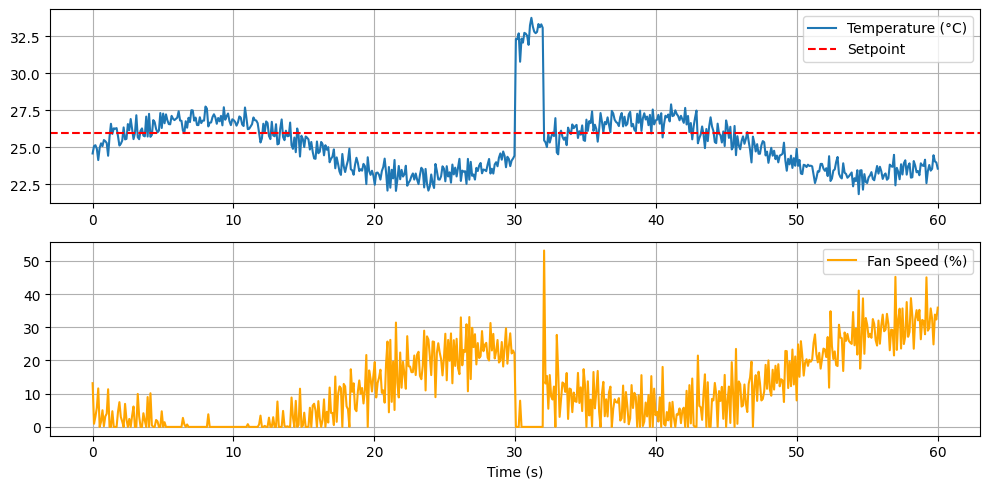

Simulating Raspberry Pi control loop...

Time: 0.0s | Temp: 24.84°C | Fan Speed: 10.8%
Time: 0.1s | Temp: 24.84°C | Fan Speed: 4.5%
Time: 0.2s | Temp: 24.59°C | Fan Speed: 7.0%
Time: 0.3s | Temp: 24.55°C | Fan Speed: 6.1%
Time: 0.4s | Temp: 25.73°C | Fan Speed: 0.0%
Time: 0.5s | Temp: 25.16°C | Fan Speed: 6.6%
Time: 0.6s | Temp: 24.84°C | Fan Speed: 6.6%
Time: 0.7s | Temp: 25.82°C | Fan Speed: 0.0%
Time: 0.8s | Temp: 24.51°C | Fan Speed: 13.3%
Time: 0.9s | Temp: 26.13°C | Fan Speed: 0.0%
Time: 1.0s | Temp: 24.72°C | Fan Speed: 13.1%
Time: 1.1s | Temp: 25.19°C | Fan Speed: 1.2%
Time: 1.2s | Temp: 25.48°C | Fan Speed: 1.1%
Time: 1.3s | Temp: 25.44°C | Fan Speed: 3.0%
Time: 1.4s | Temp: 24.81°C | Fan Speed: 8.8%
Time: 1.5s | Temp: 25.74°C | Fan Speed: 0.0%
Time: 1.6s | Temp: 25.90°C | Fan Speed: 0.3%
Time: 1.7s | Temp: 24.68°C | Fan Speed: 12.5%
Time: 1.8s | Temp: 25.50°C | Fan Speed: 0.0%
Time: 1.9s | Temp: 25.45°C | Fan Speed: 3.2%
Time: 2.0s | Temp: 26.42°C | Fan Speed: 0.0%
Time: 2.1s

In [ ]:
# Generate synthetic temperature signal
t, temperature = generate_temperature_signal()
dt = t[1] - t[0]
setpoint = 26.0

# Run Genetic Algorithm to tune PID
best_pid = genetic_algorithm(temperature, dt, setpoint)
print("✅ Optimized PID Parameters:")
print(best_pid)

# Simulate and visualize response
fan_speed, _ = simulate_pid(best_pid['Kp'], best_pid['Ki'], best_pid['Kd'], temperature, dt, setpoint)
plot_response(t, temperature, fan_speed, setpoint)

# Run Raspberry Pi-style loop
raspberry_pi_loop(best_pid['Kp'], best_pid['Ki'], best_pid['Kd'], setpoint)


FUZZY-PID CONTROL




Install Required Library

---



In [ ]:
!pip install scikit-fuzzy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.1 MB/s eta 0:00:00


Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import skfuzzy as fuzz
import skfuzzy.control as ctrl


Define Fuzzy Variables and Rules





In [ ]:
 # Inputs
error = ctrl.Antecedent(np.arange(-10, 10.1, 0.1), 'error')
delta_error = ctrl.Antecedent(np.arange(-5, 5.1, 0.1), 'delta_error')

# Outputs
Kp = ctrl.Consequent(np.arange(0, 10.1, 0.1), 'Kp')
Ki = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'Ki')
Kd = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'Kd')

# Membership functions for error
error['low'] = fuzz.trimf(error.universe, [-10, -5, 0])
error['medium'] = fuzz.trimf(error.universe, [-5, 0, 5])
error['high'] = fuzz.trimf(error.universe, [0, 5, 10])

# Membership functions for delta_error
delta_error['decreasing'] = fuzz.trimf(delta_error.universe, [-5, -2.5, 0])
delta_error['stable'] = fuzz.trimf(delta_error.universe, [-2.5, 0, 2.5])
delta_error['increasing'] = fuzz.trimf(delta_error.universe, [0, 2.5, 5])

# Membership functions for outputs
Kp['low'] = fuzz.trimf(Kp.universe, [0, 2, 4])
Kp['medium'] = fuzz.trimf(Kp.universe, [3, 5, 7])
Kp['high'] = fuzz.trimf(Kp.universe, [6, 8, 10])

Ki['low'] = fuzz.trimf(Ki.universe, [0, 0.2, 0.4])
Ki['medium'] = fuzz.trimf(Ki.universe, [0.3, 0.5, 0.7])
Ki['high'] = fuzz.trimf(Ki.universe, [0.6, 0.8, 1.0])

Kd['low'] = fuzz.trimf(Kd.universe, [0, 0.2, 0.4])
Kd['medium'] = fuzz.trimf(Kd.universe, [0.3, 0.5, 0.7])
Kd['high'] = fuzz.trimf(Kd.universe, [0.6, 0.8, 1.0])


Rule Base

In [ ]:
 rules = [
    ctrl.Rule(error['high'] & delta_error['increasing'], (Kp['high'], Ki['low'], Kd['low'])),
    ctrl.Rule(error['high'] & delta_error['stable'], (Kp['high'], Ki['medium'], Kd['medium'])),
    ctrl.Rule(error['high'] & delta_error['decreasing'], (Kp['high'], Ki['high'], Kd['high'])),

    ctrl.Rule(error['medium'] & delta_error['increasing'], (Kp['medium'], Ki['low'], Kd['low'])),
    ctrl.Rule(error['medium'] & delta_error['stable'], (Kp['medium'], Ki['medium'], Kd['medium'])),
    ctrl.Rule(error['medium'] & delta_error['decreasing'], (Kp['medium'], Ki['high'], Kd['high'])),

    ctrl.Rule(error['low'] & delta_error['increasing'], (Kp['low'], Ki['low'], Kd['low'])),
    ctrl.Rule(error['low'] & delta_error['stable'], (Kp['low'], Ki['medium'], Kd['medium'])),
    ctrl.Rule(error['low'] & delta_error['decreasing'], (Kp['low'], Ki['high'], Kd['high']))
]

fuzzy_pid_ctrl = ctrl.ControlSystem(rules)


Temperature Signal Generator

In [ ]:
 def generate_temperature_signal(duration=60, samples=600, spike_time=(30, 32), spike_magnitude=8):
    t = np.linspace(0, duration, samples)
    temperature = 25 + 2*np.sin(0.2*t) + np.random.normal(0, 0.5, len(t))
    spike_index = np.where((t > spike_time[0]) & (t < spike_time[1]))[0]
    temperature[spike_index] += spike_magnitude
    return t, temperature


Plotting Function

In [ ]:
 def plot_response(t, temperature, fan_speed, setpoint):
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 1, 1)
    plt.plot(t, temperature, label='Temperature (°C)')
    plt.axhline(setpoint, color='r', linestyle='--', label='Setpoint')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t, fan_speed, label='Fan Speed (%)', color='orange')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()


Fuzzy-PID Simulation Function

In [ ]:
 def simulate_fuzzy_pid(temperature, dt, setpoint):
    fan_speed = []
    integral = 0
    prev_error = 0

    for temp in temperature:
        error_val = np.clip(temp - setpoint, -10, 10)
        delta_error_val = np.clip(error_val - prev_error, -5, 5)

        fuzzy_pid = ctrl.ControlSystemSimulation(fuzzy_pid_ctrl)
        fuzzy_pid.input['error'] = error_val
        fuzzy_pid.input['delta_error'] = delta_error_val

        try:
            fuzzy_pid.compute()
            Kp_val = fuzzy_pid.output['Kp']
            Ki_val = fuzzy_pid.output['Ki']
            Kd_val = fuzzy_pid.output['Kd']
        except KeyError:
            Kp_val, Ki_val, Kd_val = 5.0, 0.5, 0.5  # fallback defaults

        integral += error_val * dt
        derivative = delta_error_val / dt
        output = Kp_val * error_val + Ki_val * integral + Kd_val * derivative
        prev_error = error_val

        fan_speed.append(max(0, min(100, output)))

    return fan_speed


Raspberry Pi–Style Fuzzy Loop

In [ ]:
 def raspberry_pi_fuzzy_loop(setpoint):
    t, temperature = generate_temperature_signal()
    dt = t[1] - t[0]
    integral = 0
    prev_error = 0

    print("Simulating Raspberry Pi fuzzy PID control loop...\n")

    for i in range(len(t)):
        temp = temperature[i]
        error_val = np.clip(temp - setpoint, -10, 10)
        delta_error_val = np.clip(error_val - prev_error, -5, 5)

        fuzzy_pid = ctrl.ControlSystemSimulation(fuzzy_pid_ctrl)
        fuzzy_pid.input['error'] = error_val
        fuzzy_pid.input['delta_error'] = delta_error_val

        try:
            fuzzy_pid.compute()
            Kp_val = fuzzy_pid.output['Kp']
            Ki_val = fuzzy_pid.output['Ki']
            Kd_val = fuzzy_pid.output['Kd']
        except KeyError:
            Kp_val, Ki_val, Kd_val = 5.0, 0.5, 0.5

        integral += error_val * dt
        derivative = delta_error_val / dt
        output = Kp_val * error_val + Ki_val * integral + Kd_val * derivative
        prev_error = error_val

        fan_speed = max(0, min(100, output))
        print(f"Time: {t[i]:.1f}s | Temp: {temp:.2f}°C | Fan Speed: {fan_speed:.1f}%")
        time.sleep(0.01)


Run Simulation and Real-Time Loop

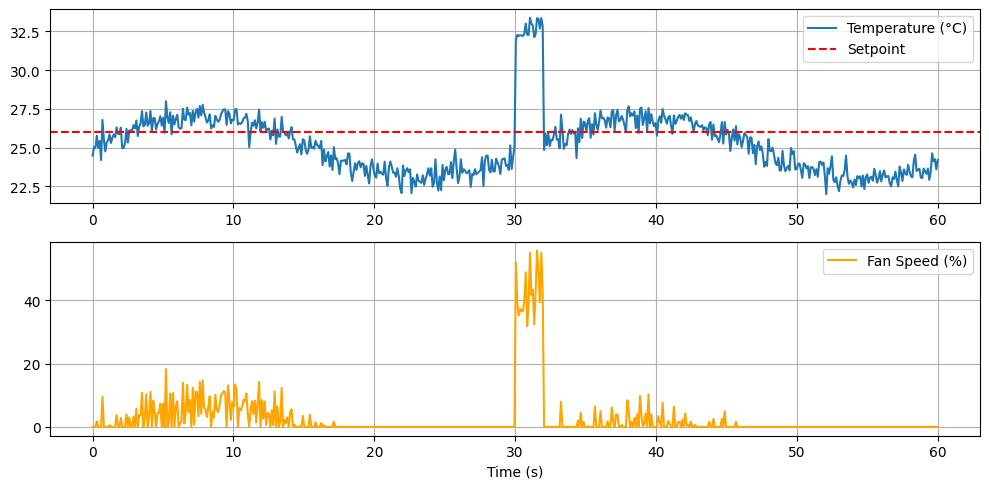

Simulating Raspberry Pi fuzzy PID control loop...

Time: 0.0s | Temp: 25.28°C | Fan Speed: 0.0%
Time: 0.1s | Temp: 25.21°C | Fan Speed: 0.0%
Time: 0.2s | Temp: 25.20°C | Fan Speed: 0.0%
Time: 0.3s | Temp: 25.37°C | Fan Speed: 0.0%
Time: 0.4s | Temp: 24.83°C | Fan Speed: 0.0%
Time: 0.5s | Temp: 24.98°C | Fan Speed: 0.0%
Time: 0.6s | Temp: 25.69°C | Fan Speed: 1.2%
Time: 0.7s | Temp: 25.73°C | Fan Speed: 0.0%
Time: 0.8s | Temp: 25.50°C | Fan Speed: 0.0%
Time: 0.9s | Temp: 25.09°C | Fan Speed: 0.0%
Time: 1.0s | Temp: 25.47°C | Fan Speed: 0.0%
Time: 1.1s | Temp: 25.10°C | Fan Speed: 0.0%
Time: 1.2s | Temp: 24.95°C | Fan Speed: 0.0%
Time: 1.3s | Temp: 25.85°C | Fan Speed: 2.3%
Time: 1.4s | Temp: 24.77°C | Fan Speed: 0.0%
Time: 1.5s | Temp: 25.54°C | Fan Speed: 0.5%
Time: 1.6s | Temp: 26.22°C | Fan Speed: 3.4%
Time: 1.7s | Temp: 25.44°C | Fan Speed: 0.0%
Time: 1.8s | Temp: 26.11°C | Fan Speed: 2.8%
Time: 1.9s | Temp: 26.46°C | Fan Speed: 3.6%
Time: 2.0s | Temp: 25.91°C | Fan Speed: 0.0%
Time

In [ ]:
setpoint = 26.0
t, temperature = generate_temperature_signal()
dt = t[1] - t[0]

fan_speed_fuzzy = simulate_fuzzy_pid(temperature, dt, setpoint)
plot_response(t, temperature, fan_speed_fuzzy, setpoint)

raspberry_pi_fuzzy_loop(setpoint)


MODEL PREDICTIVE CONTROL

Install the required libraries

In [ ]:
!pip install cvxpy

Import Libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

 MPC Simulation


In [ ]:
def simulate_mpc(temperature, dt, setpoint, horizon=10):
    a = 0.98   # thermal inertia
    b = -0.1   # cooling effect of fan
    n = len(temperature)
    fan_speed = []
    T_current = temperature[0]

    for k in range(n - horizon):
        # Define optimization variables
        u = cp.Variable(horizon)
        T = cp.Variable(horizon + 1)

        # Constraints: initial condition
        constraints = [T[0] == T_current]

        # Cost function
        cost = 0
        for t in range(horizon):
            cost += cp.square(T[t] - setpoint) + 0.01 * cp.square(u[t])
            constraints += [T[t+1] == a * T[t] + b * u[t]]
            constraints += [u[t] >= 0, u[t] <= 100]

        # Solve optimization
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve()

        # Apply first control input
        u_opt = u.value[0] if u.value is not None else 0
        fan_speed.append(u_opt)

        # Update system with chosen control
        T_current = a * T_current + b * u_opt + np.random.normal(0, 0.2)

    # Pad the end to match signal length
    fan_speed += [fan_speed[-1]] * (n - len(fan_speed))
    return fan_speed

Plotting Function

In [ ]:
 def plot_response(t, temperature, fan_speed, setpoint):
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 1, 1)
    plt.plot(t, temperature, label='Measured Temperature (°C)')
    plt.axhline(setpoint, color='r', linestyle='--', label='Setpoint')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t, fan_speed, label='Fan Speed (%)', color='purple')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

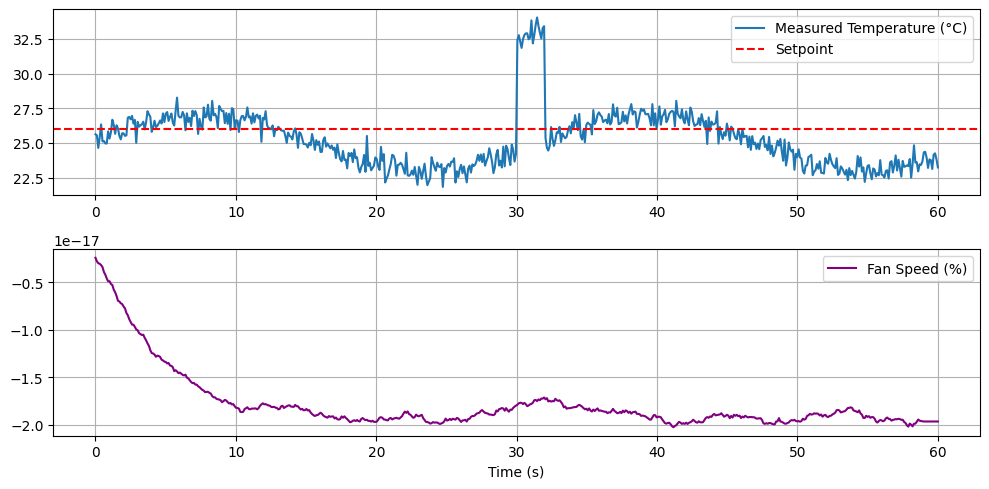

In [ ]:
setpoint = 26.0
t, temperature = generate_temperature_signal()
dt = t[1] - t[0]

fan_speed_mpc = simulate_mpc(temperature, dt, setpoint)
plot_response(t, temperature, fan_speed_mpc, setpoint)